## 1 Vehicle 

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 782 rows, 808 columns and 3512 nonzeros
Model fingerprint: 0x72319fb6
Model has 26 simple general constraints
  26 INDICATOR
Variable types: 52 continuous, 756 integer (756 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [1e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  GenCon rhs range [3e+04, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 205 rows and 180 columns
Presolve time: 0.01s
Presolved: 577 rows, 628 columns, 5320 nonzeros
Variable types: 41 continuous, 587 integer (587 binary)
Found heuristic solution: objective 7.3817952
Found heuristic solution: objective 6.9678325
Found heuristic solution: objective 6.7880467

Root relaxation: objective 1.037263e+00, 131 iterations, 0.00 seconds (0.0

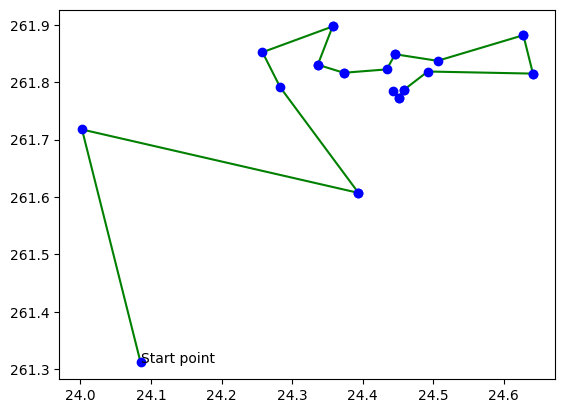

In [3]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import math
import matplotlib.pyplot as plt

# Read data
data0 = pd.read_csv("Data.tsv", delimiter="\t")

# Set nodes
xc = np.array(data0['lon'])  # x-coordinate of clients
xc = [i * 5 for i in xc]
xDepot = np.mean(xc)
xc = xc + [xDepot, xDepot]  # Convert longitude to km, including last two virtual depots' location.
yc = np.array(data0['lat'])  # y-coordinate of clients
yc = [i * 5 for i in yc]
yDepot = np.mean(yc)
yc = yc + [yDepot, yDepot]  # Convert latitude to km, including last two virtual depots' location.

# Set parameter for the vehicle
Capacity = 1000  # In the unit of liters (L)
AvgVelocity = 30  # Set average speed of the vehicle (km/h)

# Set graphical parameters of nodes
AllNodes = [i for i in range(len(xc))]   # nodes indicators. nodes n(starting) and n + 1(ending) are virtual depots.
CusNodes = AllNodes[:len(AllNodes)-2]  # Customer nodes by removing last two virtual depots.
Edges = [(i, j) for i in AllNodes for j in AllNodes if i != j]   # Edges between each pair of nodes
Distance = {(i, j): np.hypot(xc[i] - xc[j], yc[i] - yc[j])
            for i, j in Edges}  # Distances between each pair of nodes (km)

for i in range(len(AllNodes)):
    if i != len(AllNodes):
        Distance[len(AllNodes) - 2, i] = 0  # Distance of starting depot to any node is 0.

TravelTime = {(i, j): Distance[i, j] / (AvgVelocity / 3600)
              for i, j in Edges}  # Travel time between each pair of nodes (s)
PickAmount = {i: data0['size'][i] * data0['quantity'][i]
              for i in CusNodes}  # Amount to be picked from each customer

# Set time windows
ServiceTime = {i: data0['service_time'][i] for i in CusNodes}  # Set service time
time1 = data0['time_start']
time1 = [float(time1[i][0]) if time1[i][1] == ':'
         else float(time1[i][0] + time1[i][1]) for i in CusNodes]  # Convert string to float numbers
StartTime = {i: time1[i] * 3600 for i in CusNodes}  # Set starting time in units of seconds (s)
time2 = data0['time_end']
time2 = [26.0 if pd.isnull(time2[i])   # If value = nan then set the end time to a very late time.
         else float(time2[i][0]) if time2[i][1] == ':'
         else float(time2[i][0] + time2[i][1]) for i in CusNodes]
EndTime = {i: time2[i] * 3600 for i in CusNodes}  # Endtime
TimeWindow = {i: (StartTime[i], EndTime[i]) for i in CusNodes}  # Time windows for all customer nodes

# Create an optimization model
mdl = gp.Model('Seenons')

# Add decision variables
x = mdl.addVars(Edges, vtype=GRB.BINARY)  # Add decision variables x_ij
ArTime = mdl.addVars(CusNodes, vtype=GRB.CONTINUOUS)  # Arrival time at each node
DeTime = mdl.addVars(CusNodes, vtype=GRB.CONTINUOUS)  # Departure time at each node

# Add objective
mdl.modelSense = GRB.MINIMIZE
mdl.setObjective(gp.quicksum(x[i, j] * Distance[i, j] for i, j in Edges))

# Add constraints
# Constraints controlling the number of going into and out of a customer node
mdl.addConstrs(gp.quicksum(x[i, j] for j in AllNodes if j != i) == 1 for i in CusNodes)
mdl.addConstrs(gp.quicksum(x[i, j] for i in AllNodes if j != i) == 1 for j in CusNodes)
mdl.addConstr(gp.quicksum(x[(len(AllNodes) - 2), j]
                          for j in AllNodes if j != (len(AllNodes) - 2)) == 1)  # 2nd last node as virtual start depot
mdl.addConstr(gp.quicksum(x[i, (len(AllNodes) - 1)]
                          for i in AllNodes if i != (len(AllNodes) - 1)) == 1)  # Last node as virtual end depot.

# Constraints about the Time window
WorkStart = 9  # The vehicle start working time of one day
mdl.addConstrs(DeTime[i] + TravelTime[i, j] - ArTime[j] <= (1 - x[i, j]) * 90000 
               for i in CusNodes for j in CusNodes if i != j)  # 90000 as the big-M
mdl.addConstrs(DeTime[i] >= StartTime[i] + ServiceTime[i] for i in CusNodes)
mdl.addConstrs(DeTime[i] >= ArTime[i] + ServiceTime[i] for i in CusNodes)  # Constraints about the departure time.
mdl.addConstrs(ArTime[i] <= EndTime[i] for i in CusNodes)  # Constraints about the arrival time
mdl.addConstrs((x[len(AllNodes) - 2, i] == 1) >> (ArTime[i] == WorkStart * 3600)
               for i in CusNodes)   # The first nodes starts at 9:00

# Optimize
mdl.optimize()

# Out put data
SDep = len(AllNodes) - 2  # second last node in AllNodes as the start depot
EDep = len(AllNodes) - 1  # Last node in AllNodes as the end depot
ActiveEdges = [a for a in Edges if x[a].X > 0.9]  # Edges that are selected
Route = []  # A list for storing the route
sn = SDep  # Set a start node for the while loop
while sn != EDep:
    for (i, j) in ActiveEdges:
        if i == sn:
            Route = Route + [(i, j)]
            sn = j
            break
SeqNode = [i[1] for i in Route[:-1]]  # Nodes in the sequence of the route excluding two virtual nodes

# Replace the two blocks that build Output_Ar and Output_De
Output_Ar = {i: ArTime[i].X for i in SeqNode}
Output_De = {i: DeTime[i].X for i in SeqNode}

# Pretty-print as hh:mm  (zero-padded)
Output_Ar = {
    i: f"{int(t // 3600):02d}:{int((t % 3600) // 60):02d}"
    for i, t in Output_Ar.items()
}
Output_De = {
    i: f"{int(t // 3600):02d}:{int((t % 3600) // 60):02d}"
    for i, t in Output_De.items()
}

# Calculate the unloading time
nn = 0  # Node number for while-loop
TotLoad = 0  # Total load till the current node
Unload = {i: "No" for i in SeqNode}  # Indicates whether the vehicle should go unloading
while nn < len(SeqNode) - 1:
    TotLoad = TotLoad + PickAmount[SeqNode[nn]]  # Total load after serving current load
    NextLoad = TotLoad + PickAmount[SeqNode[nn + 1]]  # if the vehicle doesn't unload and go to the next node
    if NextLoad >= Capacity:     # "=" here for a buffer
        Unload[SeqNode[nn]] = "Yes"  # =1 means the vehicle need to go unloading after leaving current node
        TotLoad = 0  # Clear the load before going to the next load
    nn = nn + 1

# Output the result
print('Optimal route:\n')
print('Node\tArTime\tDeTime\tUnload\n')
for i in SeqNode:
    print('%d\t%s\t%s\t%s\n' % (i, Output_Ar[i], Output_De[i], Unload[i]))

# Plot the solution
for i, j in ActiveEdges:
    if i != SDep and j != SDep and i != EDep and j != EDep:
        plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)  # Plot active edges excluding two virtual depots

plt.scatter(xc[0:26], yc[0:26], c='b')  # Location of clients
plt.text(xc[SeqNode[0]], yc[SeqNode[0]],'Start point')
plt.show()

## 2 Vehicles

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 1538 rows, 1616 columns and 8428 nonzeros
Model fingerprint: 0x84e3a30d
Model has 52 simple general constraints
  52 INDICATOR
Variable types: 104 continuous, 1512 integer (1512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [1e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  GenCon rhs range [3e+04, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 758 rows and 420 columns
Presolve time: 0.01s
Presolved: 780 rows, 1196 columns, 5294 nonzeros
Variable types: 52 continuous, 1144 integer (1144 binary)
Found heuristic solution: objective 7.3817952

Root relaxation: objective 1.083972e+00, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wo

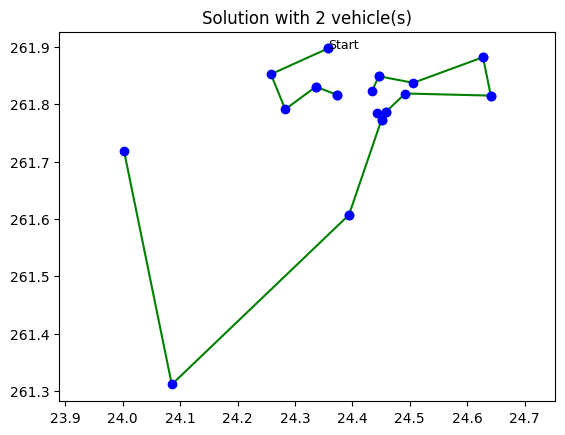

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-vehicle VRP with time windows (Gurobi)

– Reads Data.tsv exactly like your single-truck version
– Solves for m identical trucks
– Prints each truck’s route with HH:MM arrival / departure
– Flags unloading stops whenever cumulative volume would breach capacity
– Plots the solution (green lines) and client locations (blue dots)

Dependencies:
    pip install pandas numpy matplotlib gurobipy
"""

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import math
import matplotlib.pyplot as plt

# ============================================================================
# USER SETTINGS
# ============================================================================
m            = 2          # number of vehicles
Capacity     = 1000       # litres
AvgVelocity  = 30         # km/h
WorkStart    = 9 * 3600   # seconds  (09:00)

# ============================================================================
# DATA -----------------------------------------------------------------------
# ============================================================================
data0 = pd.read_csv("Data.tsv", delimiter="\t")

# coordinates (simple 5× scale to make small DD coords look like km)
xc = list(data0['lon'] * 5)
yc = list(data0['lat'] * 5)
xDepot = np.mean(xc)
yDepot = np.mean(yc)
xc += [xDepot, xDepot]     # two virtual depots (start & end)
yc += [yDepot, yDepot]

AllNodes = list(range(len(xc)))
CusNodes = AllNodes[:-2]                # drop the two depot indices
SDep, EDep = len(AllNodes) - 2, len(AllNodes) - 1

Edges     = [(i, j) for i in AllNodes for j in AllNodes if i != j]
Distance  = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in Edges}
for i in AllNodes:                      # start-depot arcs cost = 0
    Distance[SDep, i] = 0
TravelTime = {(i, j): Distance[i, j] / (AvgVelocity/3600) for i, j in Edges}

PickAmount   = {i: data0['size'][i] * data0['quantity'][i] for i in CusNodes}
ServiceTime  = {i: data0['service_time'][i]                  for i in CusNodes}

# convert 'HH' or 'H:' style strings to hours float
time1 = [float(ts[0]) if ts[1] == ':' else float(ts[:2]) for ts in data0['time_start']]
time2 = [26.0 if pd.isna(te) else
         (float(te[0]) if te[1] == ':' else float(te[:2])) for te in data0['time_end']]
StartTime = {i: time1[i]*3600 for i in CusNodes}
EndTime   = {i: time2[i]*3600 for i in CusNodes}

# ============================================================================
# MODEL ----------------------------------------------------------------------
# ============================================================================
mdl = gp.Model("Seenons_multi")

K = range(m)                                          # vehicle set

x  = mdl.addVars(Edges, K, vtype=GRB.BINARY,     name="x")     # routing
Ar = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="arr")
De = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="dep")

# Objective – minimise total driven distance
mdl.setObjective(gp.quicksum(x[i, j, k] * Distance[i, j]
                             for i, j in Edges for k in K),
                 GRB.MINIMIZE)

# 1. Every customer visited exactly once
mdl.addConstrs(
    gp.quicksum(x[i, j, k] for i in AllNodes if i != j for k in K) == 1
    for j in CusNodes)

# 2. Flow conservation per vehicle
for k in K:
    # leave start depot once, enter end depot once
    mdl.addConstr(gp.quicksum(x[SDep, j, k] for j in AllNodes if j != SDep) == 1)
    mdl.addConstr(gp.quicksum(x[i, EDep, k] for i in AllNodes if i != EDep) == 1)
    # in-degree = out-degree on each customer node
    mdl.addConstrs(
        gp.quicksum(x[i, j, k] for i in AllNodes if i != j) ==
        gp.quicksum(x[j, h, k] for h in AllNodes if h != j)
        for j in CusNodes)

# 3. Time-window & sequencing logic
M = 90000
mdl.addConstrs(De[i, k] >= Ar[i, k] + ServiceTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] >= StartTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] <= EndTime[i]
               for i in CusNodes for k in K)

mdl.addConstrs(
    De[i, k] + TravelTime[i, j] - Ar[j, k] <= (1 - x[i, j, k]) * M
    for i in CusNodes for j in CusNodes if i != j for k in K)

mdl.addConstrs(
    (x[SDep, j, k] == 1) >> (Ar[j, k] == WorkStart)
    for j in CusNodes for k in K)

# ============================================================================
# SOLVE ----------------------------------------------------------------------
# ============================================================================
mdl.optimize()

# ──────────── after mdl.optimize() ─────────────────
if mdl.status == GRB.OPTIMAL:
    total_cost = mdl.ObjVal
    print(f"\nTotal distance (cost) = {total_cost:.2f} km\n")
else:
    print("\nNo optimal solution found, status:", mdl.status, "\n")


# ============================================================================
# POST-PROCESSING ------------------------------------------------------------
# ============================================================================
def sec_to_hhmm(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    return f"{h:02d}:{m:02d}"

print("\n================  SOLUTION  ================\n")

for k in K:
    # collect active arcs for vehicle k
    active = [(i, j) for i, j in Edges if x[i, j, k].X > 0.9]
    if not active:         # vehicle parked all day (possible when m large)
        print(f"Vehicle {k}: not used.\n")
        continue

    # reconstruct route
    route, sn = [], SDep
    while sn != EDep:
        for (i, j) in active:
            if i == sn:
                route.append((i, j)); sn = j; break
    seq = [t[1] for t in route[:-1]]            # drop the final depot

    # unloading logic
    unload = {i: "No" for i in seq}
    totload = 0
    for idx, node in enumerate(seq[:-1]):
        totload += PickAmount[node]
        nextload = totload + PickAmount[seq[idx+1]]
        if nextload >= Capacity:
            unload[node] = "Yes"
            totload = 0

    # pretty print
    print(f"Vehicle {k}")
    print("Node  Arr    Dep    Unload")
    for n in seq:
        arr = sec_to_hhmm(Ar[n, k].X)
        dep = sec_to_hhmm(De[n, k].X)
        print(f"{n:>4}  {arr}  {dep}   {unload[n]}")
    print()

    # plotting
    for (i, j) in active:
        if i not in (SDep, EDep) and j not in (SDep, EDep):
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)

# scatter all clients once
plt.scatter(xc[:-2], yc[:-2], c='b', zorder=3)
plt.text(xc[seq[0]], yc[seq[0]], "Start", fontsize=9)
plt.title(f"Solution with {m} vehicle(s)")
plt.axis('equal')
plt.show()


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 1538 rows, 1616 columns and 8428 nonzeros
Model fingerprint: 0x84e3a30d
Model has 52 simple general constraints
  52 INDICATOR
Variable types: 104 continuous, 1512 integer (1512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [1e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  GenCon rhs range [3e+04, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 758 rows and 420 columns
Presolve time: 0.01s
Presolved: 780 rows, 1196 columns, 5294 nonzeros
Variable types: 52 continuous, 1144 integer (1144 binary)
Found heuristic solution: objective 7.3817952

Root relaxation: objective 1.083972e+00, 84 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wo

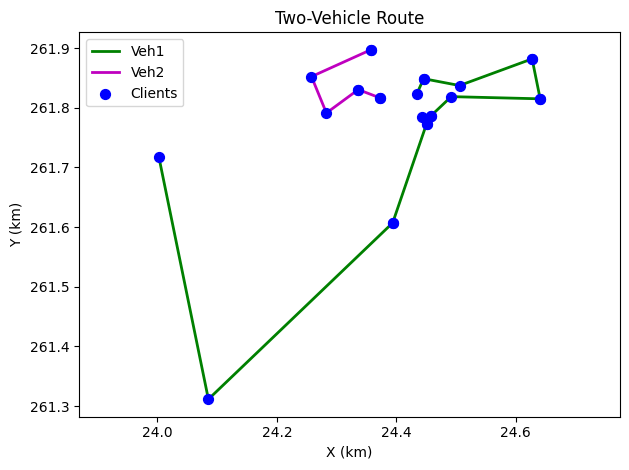

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-vehicle VRP with time windows (Gurobi), using the same color scheme as our OR-Tools version:
— Routes in green
— Client locations in blue
"""

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import math
import matplotlib.pyplot as plt

# ============================================================================
# USER SETTINGS
# ============================================================================
m           = 2          # number of vehicles
Capacity    = 1000       # litres
AvgVelocity = 30         # km/h
WorkStart   = 9 * 3600   # seconds (09:00)

# ============================================================================
# DATA
# ============================================================================
data0 = pd.read_csv("Data.tsv", delimiter="\t")

xc = list(data0['lon'] * 5)
yc = list(data0['lat'] * 5)
xDepot = np.mean(xc)
yDepot = np.mean(yc)
xc += [xDepot, xDepot]    # virtual start & end depots
yc += [yDepot, yDepot]

AllNodes = list(range(len(xc)))
CusNodes = AllNodes[:-2]
SDep, EDep = len(AllNodes)-2, len(AllNodes)-1

Edges      = [(i, j) for i in AllNodes for j in AllNodes if i != j]
Distance   = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in Edges}
for i in AllNodes:
    Distance[SDep, i] = 0
TravelTime = {(i, j): Distance[i,j] / (AvgVelocity/3600) for i,j in Edges}

PickAmount  = {i: data0['size'][i] * data0['quantity'][i] for i in CusNodes}
ServiceTime = {i: data0['service_time'][i]                for i in CusNodes}

time1 = [float(ts[0]) if ts[1]==':' else float(ts[:2]) for ts in data0['time_start']]
time2 = [26.0 if pd.isna(te) else (float(te[0]) if te[1]==':' else float(te[:2]))
         for te in data0['time_end']]
StartTime = {i: time1[i]*3600 for i in CusNodes}
EndTime   = {i: time2[i]*3600 for i in CusNodes}

# ============================================================================
# MODEL
# ============================================================================
mdl = gp.Model("Seenons_multi")
K   = range(m)

x  = mdl.addVars(Edges, K, vtype=GRB.BINARY,     name="x")
Ar = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="arr")
De = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="dep")

mdl.setObjective(
    gp.quicksum(x[i,j,k]*Distance[i,j] for i,j in Edges for k in K),
    GRB.MINIMIZE
)

# 1) each customer exactly once
mdl.addConstrs(
    gp.quicksum(x[i,j,k] for i in AllNodes if i!=j for k in K) == 1
    for j in CusNodes
)

# 2) flow conservation per vehicle
for k in K:
    mdl.addConstr(gp.quicksum(x[SDep,j,k] for j in AllNodes if j!=SDep) == 1)
    mdl.addConstr(gp.quicksum(x[i,EDep,k] for i in AllNodes if i!=EDep) == 1)
    mdl.addConstrs(
        gp.quicksum(x[i,j,k] for i in AllNodes if i!=j) ==
        gp.quicksum(x[j,h,k] for h in AllNodes if h!=j)
        for j in CusNodes
    )

# 3) time‐windows & sequencing
M = 90000
mdl.addConstrs(De[i,k] >= Ar[i,k] + ServiceTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i,k] >= StartTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i,k] <= EndTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(
    De[i,k] + TravelTime[i,j] - Ar[j,k] <= (1 - x[i,j,k]) * M
    for i in CusNodes for j in CusNodes if i!=j for k in K
)
mdl.addConstrs(
    (x[SDep,j,k] == 1) >> (Ar[j,k] == WorkStart)
    for j in CusNodes for k in K
)

# ============================================================================
# SOLVE
# ============================================================================
mdl.optimize()

# ──────────── print total cost
if mdl.status == GRB.OPTIMAL:
    print(f"\nTotal distance (cost) = {mdl.ObjVal:.2f} km\n")
else:
    print(f"\nNo optimal solution (status {mdl.status})\n")

# ============================================================================
# POST-PROCESSING
# ============================================================================
def sec_to_hhmm(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    return f"{h:02d}:{m:02d}"

print("===== SOLUTION =====\n")
for k in K:
    active = [(i,j) for i,j in Edges if x[i,j,k].X > 0.9]
    if not active:
        print(f"Vehicle {k}: not used\n")
        continue

    route, sn = [], SDep
    while sn != EDep:
        for (i,j) in active:
            if i == sn:
                route.append((i,j))
                sn = j
                break
    seq = [j for _,j in route[:-1]]

    unload = {i:"No" for i in seq}
    load   = 0
    for idx,node in enumerate(seq[:-1]):
        load += PickAmount[node]
        if load + PickAmount[seq[idx+1]] >= Capacity:
            unload[node] = "Yes"
            load = 0

    print(f"Vehicle {k}")
    print("Node  Arr   Dep   Unload")
    for n in seq:
        print(f"{n:>4}  {sec_to_hhmm(Ar[n,k].X)}  {sec_to_hhmm(De[n,k].X)}   {unload[n]}")
    print()

# ============================================================================
# PLOTTING (use same colors & legend as OR-Tools)
# ============================================================================

colors = ['g', 'm']            # Veh1=green, Veh2=magenta
labels_shown = [False, False]  # track first segment per vehicle

for k in K:
    # collect active arcs for vehicle k
    active = [(i, j) for i, j in Edges if x[i, j, k].X > 0.9]
    for (i, j) in active:
        # skip virtual depots
        if i in (SDep, EDep) or j in (SDep, EDep):
            continue
        # label only on the first plotted segment per vehicle
        lbl = f"Veh{k+1}" if not labels_shown[k] else None
        plt.plot(
            [xc[i], xc[j]],
            [yc[i], yc[j]],
            color=colors[k],
            linewidth=2,
            zorder=0,
            label=lbl
        )
        labels_shown[k] = True

# clients as blue dots
plt.scatter(
    xc[:-2], yc[:-2],
    color='b',
    s=50,
    zorder=1,
    label='Clients'
)

plt.title("Two-Vehicle Route") 
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()



## Many points and vehicles

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-vehicle VRP with time windows (Gurobi)

– Reads Data.tsv exactly like your single-truck version
– Solves for m identical trucks
– Prints each truck’s route with HH:MM arrival / departure
– Flags unloading stops whenever cumulative volume would breach capacity
– Plots the solution (green lines) and client locations (blue dots)

Dependencies:
    pip install pandas numpy matplotlib gurobipy
"""

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import math
import matplotlib.pyplot as plt

# ============================================================================
# USER SETTINGS
# ============================================================================
m            = 15          # number of vehicles
Capacity     = 1000       # litres
AvgVelocity  = 30         # km/h
WorkStart    = 9 * 3600   # seconds  (09:00)

# ============================================================================
# DATA -----------------------------------------------------------------------
# ============================================================================
data0 = pd.read_csv("Data_200.tsv", delimiter="\t")

# coordinates (simple 5× scale to make small DD coords look like km)
xc = list(data0['lon'] * 5)
yc = list(data0['lat'] * 5)
xDepot = np.mean(xc)
yDepot = np.mean(yc)
xc += [xDepot, xDepot]     # two virtual depots (start & end)
yc += [yDepot, yDepot]

AllNodes = list(range(len(xc)))
CusNodes = AllNodes[:-2]                # drop the two depot indices
SDep, EDep = len(AllNodes) - 2, len(AllNodes) - 1

Edges     = [(i, j) for i in AllNodes for j in AllNodes if i != j]
Distance  = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in Edges}
for i in AllNodes:                      # start-depot arcs cost = 0
    Distance[SDep, i] = 0
TravelTime = {(i, j): Distance[i, j] / (AvgVelocity/3600) for i, j in Edges}

PickAmount   = {i: data0['size'][i] * data0['quantity'][i] for i in CusNodes}
ServiceTime  = {i: data0['service_time'][i]                  for i in CusNodes}

# convert 'HH' or 'H:' style strings to hours float
time1 = [float(ts[0]) if ts[1] == ':' else float(ts[:2]) for ts in data0['time_start']]
time2 = [26.0 if pd.isna(te) else
         (float(te[0]) if te[1] == ':' else float(te[:2])) for te in data0['time_end']]
StartTime = {i: time1[i]*3600 for i in CusNodes}
EndTime   = {i: time2[i]*3600 for i in CusNodes}

# ============================================================================
# MODEL ----------------------------------------------------------------------
# ============================================================================
mdl = gp.Model("Seenons_multi")

K = range(m)                                          # vehicle set

x  = mdl.addVars(Edges, K, vtype=GRB.BINARY,     name="x")     # routing
Ar = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="arr")
De = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="dep")

# Objective – minimise total driven distance
mdl.setObjective(gp.quicksum(x[i, j, k] * Distance[i, j]
                             for i, j in Edges for k in K),
                 GRB.MINIMIZE)

# 1. Every customer visited exactly once
mdl.addConstrs(
    gp.quicksum(x[i, j, k] for i in AllNodes if i != j for k in K) == 1
    for j in CusNodes)

# 2. Flow conservation per vehicle
for k in K:
    # leave start depot once, enter end depot once
    mdl.addConstr(gp.quicksum(x[SDep, j, k] for j in AllNodes if j != SDep) == 1)
    mdl.addConstr(gp.quicksum(x[i, EDep, k] for i in AllNodes if i != EDep) == 1)
    # in-degree = out-degree on each customer node
    mdl.addConstrs(
        gp.quicksum(x[i, j, k] for i in AllNodes if i != j) ==
        gp.quicksum(x[j, h, k] for h in AllNodes if h != j)
        for j in CusNodes)

# 3. Time-window & sequencing logic
M = 90000
mdl.addConstrs(De[i, k] >= Ar[i, k] + ServiceTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] >= StartTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] <= EndTime[i]
               for i in CusNodes for k in K)

mdl.addConstrs(
    De[i, k] + TravelTime[i, j] - Ar[j, k] <= (1 - x[i, j, k]) * M
    for i in CusNodes for j in CusNodes if i != j for k in K)

mdl.addConstrs(
    (x[SDep, j, k] == 1) >> (Ar[j, k] == WorkStart)
    for j in CusNodes for k in K)

# ============================================================================
# SOLVE ----------------------------------------------------------------------
# ============================================================================
# impose a 20-second time limit
mdl.setParam(GRB.Param.TimeLimit, 20)

mdl.optimize()

# ============================================================================
# POST-PROCESSING ------------------------------------------------------------
# ============================================================================
def sec_to_hhmm(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    return f"{h:02d}:{m:02d}"

print("\n================  SOLUTION  ================\n")

for k in K:
    # collect active arcs for vehicle k
    active = [(i, j) for i, j in Edges if x[i, j, k].X > 0.9]
    if not active:         # vehicle parked all day (possible when m large)
        print(f"Vehicle {k}: not used.\n")
        continue

    # reconstruct route
    route, sn = [], SDep
    while sn != EDep:
        for (i, j) in active:
            if i == sn:
                route.append((i, j)); sn = j; break
    seq = [t[1] for t in route[:-1]]            # drop the final depot

    # unloading logic
    unload = {i: "No" for i in seq}
    totload = 0
    for idx, node in enumerate(seq[:-1]):
        totload += PickAmount[node]
        nextload = totload + PickAmount[seq[idx+1]]
        if nextload >= Capacity:
            unload[node] = "Yes"
            totload = 0

    # pretty print
    print(f"Vehicle {k}")
    print("Node  Arr    Dep    Unload")
    for n in seq:
        arr = sec_to_hhmm(Ar[n, k].X)
        dep = sec_to_hhmm(De[n, k].X)
        print(f"{n:>4}  {arr}  {dep}   {unload[n]}")
    print()

    # plotting
    for (i, j) in active:
        if i not in (SDep, EDep) and j not in (SDep, EDep):
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)

# scatter all clients once
plt.scatter(xc[:-2], yc[:-2], c='b', zorder=3)
plt.text(xc[seq[0]], yc[seq[0]], "Start", fontsize=9)
plt.title(f"Solution with {m} vehicle(s)")
plt.axis('equal')
plt.show()


Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 609230 rows, 615030 columns and 3618030 nonzeros
Model fingerprint: 0xde004b4f
Model has 3000 simple general constraints
  3000 INDICATOR
Variable types: 6000 continuous, 609030 integer (609030 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  GenCon rhs range [3e+04, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 114885 rows and 86385 columns
Presolve time: 4.72s
Presolved: 494345 rows, 528645 columns, 3036765 nonzeros
Variable types: 3000 continuous, 525645 integer (525645 binary)
Found heuristic solution: objective 7607.0228755
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrie

KeyboardInterrupt: 

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[arm] - Darwin 24.6.0 24G84)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 609230 rows, 615030 columns and 3618030 nonzeros
Model fingerprint: 0xde004b4f
Model has 3000 simple general constraints
  3000 INDICATOR
Variable types: 6000 continuous, 609030 integer (609030 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+04]
  Objective range  [2e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  GenCon rhs range [3e+04, 3e+04]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 114885 rows and 86385 columns
Presolve time: 4.72s
Presolved: 494345 rows, 528645 columns, 3036765 nonzeros
Variable types: 3000 continuous, 525645 integer (525645 binary)
Found heuristic solution: objective 7607.0228755
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.02s

Barrier performed 0 iterations in 6.81 seconds (17.45 work units)
Barrier solve interrupted - model solved by another algorithm

Concurrent spin time: 0.07s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     601    4.7272722e+02   0.000000e+00   0.000000e+00      7s

Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 7s

    1553 PPushes remaining with PInf 0.0000000e+00                 7s
       0 PPushes remaining with PInf 0.0000000e+00                 7s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6954681e+01      7s


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    4847    4.7272722e+02   0.000000e+00   1.695468e+01      7s
    6017    4.7272721e+02   0.000000e+00   2.948591e+00     10s
    6735    4.7272722e+02   0.000000e+00   0.000000e+00     11s

Root relaxation: objective 4.727272e+02, 6735 iterations, 4.84 seconds (20.42 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  472.72722    0  409 7607.02288  472.72722  93.8%     -   12s
H    0     0                    1897.9750816  472.72722  75.1%     -   12s
H    0     0                    1592.2043408  472.72722  70.3%     -   12s
H    0     0                    1577.2191919  472.72722  70.0%     -   12s
H    0     0                    1576.3596027  472.72722  70.0%     -   12s
H    0     0                    1554.6925703  472.72722  69.6%     -   12s
H    0     0                    1530.2674144  472.72722  69.1%     -   12s
H    0     0                    1522.7933435  472.72722  69.0%     -   12s
H    0     0                    1511.3380126  472.72722  68.7%     -   12s
H    0     0                    1502.0341934  472.72722  68.5%     -   12s
H    0     0                    1482.6100635  472.72722  68.1%     -   12s
H    0     0                    1465.8004952  472.72722  67.7%     -   13s
H    0     0                    1457.4110076  472.72722  67.6%     -   13s
H    0     0                    1455.5214626  472.72722  67.5%     -   13s
H    0     0                    1451.7887254  472.72722  67.4%     -   13s
H    0     0                    1435.2142266  472.72722  67.1%     -   15s
H    0     0                    1409.2497682  472.72722  66.5%     -   15s
H    0     0                    1393.9449956  472.72722  66.1%     -   16s
H    0     0                    1382.0841488  472.72722  65.8%     -   17s
H    0     0                    1357.1795228  472.72722  65.2%     -   17s
H    0     0                    1355.3770218  472.72722  65.1%     -   18s
H    0     0                    1347.8664970  472.72722  64.9%     -   18s
H    0     0                    1346.2466036  472.72722  64.9%     -   18s
H    0     0                    1339.6889334  472.72722  64.7%     -   18s
H    0     0                    1337.8225114  472.72722  64.7%     -   18s
H    0     0                    1303.8025829  472.72722  63.7%     -   19s
H    0     0                    1293.7095815  472.72722  63.5%     -   20s
H    0     0                    1287.0059584  472.72722  63.3%     -   20s
H    0     0                    1267.6308926  472.72722  62.7%     -   21s
     0     0  472.72722    0  464 1267.63089  472.72722  62.7%     -   24s
H    0     0                    1265.3579199  472.72722  62.6%     -   26s
H    0     0                    1258.3665815  472.72722  62.4%     -   31s
H    0     0                    1218.7850162  472.72722  61.2%     -   33s
H    0     0                    1206.4777854  472.72722  60.8%     -   34s
H    0     0                    1175.3014576  472.72722  59.8%     -   35s
H    0     0                    1163.0265719  472.72722  59.4%     -   35s
H    0     0                    1158.2525523  472.72722  59.2%     -   35s
H    0     0                    1154.5982078  472.72722  59.1%     -   36s
H    0     0                    1153.9923116  472.72722  59.0%     -   38s
H    0     0                    1152.2530096  472.72722  59.0%     -   38s
H    0     0                    1152.2330937  472.72722  59.0%     -   38s
H    0     0                    1152.1965208  472.72722  59.0%     -   38s
H    0     0                    1150.3689214  472.72722  58.9%     -   38s
     0     0  472.72722    0  519 1150.36892  472.72722  58.9%     -   39s
     0     0  472.72722    0  409 1150.36892  472.72722  58.9%     -   43s
     0     0  472.72722    0  455 1150.36892  472.72722  58.9%     -   45s
     0     0  472.72722    0  418 1150.36892  472.72722  58.9%     -   50s
     0     0  472.72722    0  463 1150.36892  472.72722  58.9%     -   51s
     0     0  472.72722    0  410 1150.36892  472.72722  58.9%     -   56s
     0     0  472.72722    0  436 1150.36892  472.72722  58.9%     -   58s
     0     0  472.81205    0  417 1150.36892  472.81205  58.9%     -   64s
     0     0  473.69099    0  451 1150.36892  473.69099  58.8%     -   72s
     0     0  482.91783    0  440 1150.36892  482.91783  58.0%     -   75s
     0     0  483.30814    0  434 1150.36892  483.30814  58.0%     -   77s
     0     0  483.30814    0  452 1150.36892  483.30814  58.0%     -   81s
     0     0  488.16095    0  583 1150.36892  488.16095  57.6%     -   88s
     0     0  493.98380    0  562 1150.36892  493.98380  57.1%     -   92s
     0     0  493.99334    0  527 1150.36892  493.99334  57.1%     -   94s
     0     0  493.99334    0  546 1150.36892  493.99334  57.1%     -   96s
     0     0  513.84822    0  551 1150.36892  513.84822  55.3%     -  106s
     0     0  514.38596    0  554 1150.36892  514.38596  55.3%     -  112s
     0     0  514.38596    0  547 1150.36892  514.38596  55.3%     -  114s
     0     0  522.33637    0  610 1150.36892  522.33637  54.6%     -  125s
H    0     0                    1144.4466874  522.33637  54.4%     -  130s
H    0     0                    1139.6718133  522.33637  54.2%     -  132s
H    0     0                    1134.7364004  522.33637  54.0%     -  133s
H    0     0                    1134.6506381  522.33637  54.0%     -  134s
H    0     0                    1120.7359184  522.33637  53.4%     -  136s
H    0     0                    1119.2766278  522.33637  53.3%     -  136s
H    0     0                    1105.9635761  522.33637  52.8%     -  142s
H    0     0                    1090.5372000  522.33637  52.1%     -  143s
H    0     0                    1086.2904881  522.33637  51.9%     -  148s
H    0     0                    1072.6540375  522.33637  51.3%     -  154s
H    0     0                    1058.1429049  522.33637  50.6%     -  154s
H    0     0                    1057.1962151  522.33637  50.6%     -  157s
     0     0  522.48033    0  575 1057.19622  522.48033  50.6%     -  165s
     0     0  522.48819    0  533 1057.19622  522.48819  50.6%     -  168s
     0     0  527.68903    0  569 1057.19622  527.68903  50.1%     -  174s
H    0     0                    1056.5522352  527.68903  50.1%     -  177s
H    0     0                    1056.4749691  527.68903  50.1%     -  177s
H    0     0                    1054.9697841  527.68903  50.0%     -  177s
     0     0  527.70962    0  529 1054.96978  527.70962  50.0%     -  178s
     0     0  527.70962    0  543 1054.96978  527.70962  50.0%     -  179s
     0     0  531.25857    0  596 1054.96978  531.25857  49.6%     -  189s
     0     0  531.80190    0  573 1054.96978  531.80190  49.6%     -  193s
     0     0  531.80190    0  542 1054.96978  531.80190  49.6%     -  194s
     0     0  532.73546    0  532 1054.96978  532.73546  49.5%     -  214s
H    0     0                    1053.5022809  532.73546  49.4%     -  215s
     0     0  532.77288    0  477 1053.50228  532.77288  49.4%     -  220s
     0     0  533.14763    0  471 1053.50228  533.14763  49.4%     -  223s
     0     0  533.14763    0  459 1053.50228  533.14763  49.4%     -  224s
     0     0  534.73245    0  547 1053.50228  534.73245  49.2%     -  234s
     0     0  534.73245    0  513 1053.50228  534.73245  49.2%     -  238s
     0     0  535.07113    0  484 1053.50228  535.07113  49.2%     -  243s
H    0     0                    1051.5849845  535.07113  49.1%     -  251s
H    0     0                    1012.7567406  535.07113  47.2%     -  253s
H    0     0                    1012.7423769  535.07113  47.2%     -  254s
H    0     0                    1008.6382857  535.07113  47.0%     -  255s
H    0     0                    1002.7430946  535.07113  46.6%     -  256s
H    0     0                     990.6857533  535.07113  46.0%     -  258s
H    0     0                     990.2647382  535.07113  46.0%     -  262s
H    0     0                     982.5189526  535.07113  45.5%     -  264s
H    0     0                     981.8056150  535.07113  45.5%     -  266s
H    0     0                     977.5540031  535.07113  45.3%     -  276s
H    0     0                     972.2501258  535.07113  45.0%     -  277s
H    0     0                     963.9545942  535.07113  44.5%     -  293s
H    0     0                     958.8916078  535.07113  44.2%     -  300s
H    0     0                     958.6517903  535.07113  44.2%     -  300s
H    0     0                     955.2250132  535.07113  44.0%     -  302s
H    0     0                     954.2769447  535.07113  43.9%     -  302s
H    0     0                     953.3819264  535.07113  43.9%     -  302s
H    0     0                     950.4827601  535.07113  43.7%     -  305s
H    0     0                     949.6867425  535.07113  43.7%     -  321s
H    0     0                     948.7267821  535.07113  43.6%     -  321s
H    0     0                     947.3114772  535.07113  43.5%     -  325s
H    0     0                     942.8670866  535.07113  43.3%     -  328s
H    0     0                     942.2235176  535.07113  43.2%     -  328s
H    0     0                     941.5989857  535.07113  43.2%     -  328s
H    0     0                     938.7892825  535.07113  43.0%     -  328s
     0     0  535.09820    0  515  938.78928  535.09820  43.0%     -  335s
     0     0  535.09820    0  498  938.78928  535.09820  43.0%     -  336s
     0     0  536.04325    0  587  938.78928  536.04325  42.9%     -  344s
     0     0  536.14553    0  560  938.78928  536.14553  42.9%     -  349s
     0     0  536.15587    0  518  938.78928  536.15587  42.9%     -  351s
     0     0  538.11440    0  577  938.78928  538.11440  42.7%     -  366s
     0     0  538.11440    0  524  938.78928  538.11440  42.7%     -  369s
     0     0  540.17049    0  538  938.78928  540.17049  42.5%     -  377s
     0     0  540.17049    0  583  938.78928  540.17049  42.5%     -  380s
     0     0  542.33070    0  566  938.78928  542.33070  42.2%     -  386s
     0     0  542.46754    0  496  938.78928  542.46754  42.2%     -  387s
     0     0  542.46754    0  492  938.78928  542.46754  42.2%     -  388s
     0     0  543.75470    0  589  938.78928  543.75470  42.1%     -  395s
     0     0  543.76677    0  664  938.78928  543.76677  42.1%     -  451s
     0     0  544.68089    0  537  938.78928  544.68089  42.0%     -  484s
     0     0  545.80957    0  628  938.78928  545.80957  41.9%     -  567s
     0     0  545.80957    0  603  938.78928  545.80957  41.9%     -  569s
     0     0  546.51175    0  541  938.78928  546.51175  41.8%     -  576s
H    0     0                     938.3404307  546.51175  41.8%     -  579s
H    0     0                     937.4381649  546.51175  41.7%     -  580s
H    0     0                     937.0962898  546.51175  41.7%     -  581s
H    0     0                     936.6421288  546.51175  41.7%     -  583s
H    0     0                     931.0698447  546.51175  41.3%     -  583s
     0     0  546.51175    0  516  931.06984  546.51175  41.3%     -  584s
     0     0  547.52076    0  617  931.06984  547.52076  41.2%     -  590s
     0     0  547.78486    0  610  931.06984  547.78486  41.2%     -  653s
     0     0  547.78486    0  552  931.06984  547.78486  41.2%     -  683s
     0     0  548.84164    0  659  931.06984  548.84164  41.1%     -  690s
H    0     0                     929.7512092  548.84164  41.0%     -  693s
H    0     0                     927.1504775  548.84164  40.8%     -  694s
H    0     0                     926.0271353  548.84164  40.7%     -  695s
H    0     0                     920.1754194  548.84164  40.4%     -  695s
H    0     0                     920.0263756  548.84164  40.3%     -  696s
H    0     0                     919.1514045  548.84164  40.3%     -  697s
H    0     0                     916.0840961  548.84164  40.1%     -  697s
     0     0  548.94024    0  619  916.08410  548.94024  40.1%     -  704s
     0     0  548.94024    0  629  916.08410  548.94024  40.1%     -  706s
     0     0  549.23270    0  546  916.08410  549.23270  40.0%     -  711s
     0     0  549.29916    0  529  916.08410  549.29916  40.0%     -  716s
     0     0  549.29916    0  531  916.08410  549.29916  40.0%     -  718s
     0     0  549.98727    0  564  916.08410  549.98727  40.0%     -  757s
H    0     0                     915.7319120  549.98727  39.9%     -  761s
     0     0  550.18626    0  639  915.73191  550.18626  39.9%     -  765s
     0     0  550.18626    0  584  915.73191  550.18626  39.9%     -  766s
     0     0  551.16503    0  618  915.73191  551.16503  39.8%     -  773s
     0     0  551.17414    0  646  915.73191  551.17414  39.8%     -  778s
     0     0  551.46158    0  703  915.73191  551.46158  39.8%     -  783s
H    0     0                     914.8925887  551.46158  39.7%     -  788s
H    0     0                     910.9807256  551.46158  39.5%     -  788s
     0     0  551.53367    0  542  910.98073  551.53367  39.5%     -  791s
     0     0  551.53367    0  521  910.98073  551.53367  39.5%     -  792s
     0     0  551.64605    0  522  910.98073  551.64605  39.4%     -  796s
     0     0  551.64605    0  540  910.98073  551.64605  39.4%     -  799s
     0     0  551.65686    0  698  910.98073  551.65686  39.4%     -  803s
     0     0  551.65686    0  436  910.98073  551.65686  39.4%     -  812s
H    0     0                     910.7820094  557.65288  38.8%     - 1000s
H    0     0                     909.9103935  557.65288  38.7%     - 1008s
H    0     0                     909.4770968  557.65288  38.7%     - 1014s
H    0     0                     903.9496210  557.65288  38.3%     - 1018s
H    0     0                     902.6753266  557.65288  38.2%     - 1028s
H    0     0                     900.9299109  557.65288  38.1%     - 1033s
     0     2  557.65288    0  403  900.92991  557.65288  38.1%     - 1040s
     1     3  557.65288    1  512  900.92991  557.65288  38.1%  8154 1047s
     2     6  557.65288    2  622  900.92991  557.65288  38.1%  6050 1061s
     5    12  557.65288    3  647  900.92991  557.65288  38.1%  4959 1071s
    11    22  557.65288    4  619  900.92991  557.65288  38.1%  3449 1094s
    21    36  557.65288    5  588  900.92991  557.65288  38.1%  3324 1112s
    35    86  557.65288    6  586  900.92991  557.65288  38.1%  2604 1130s
    85   114  557.65288   10  576  900.92991  557.65288  38.1%  1319 1142s
   113   137  557.65288   11  636  900.92991  557.65288  38.1%  1126 1153s
   136   157  557.65288   12  632  900.92991  557.65288  38.1%  1007 1163s
   156   187  557.65288   13  640  900.92991  557.65288  38.1%   974 1175s
   186   201  557.65288   16  597  900.92991  557.65288  38.1%   900 1188s
   200   216  557.65288   16  617  900.92991  557.65288  38.1%   891 1209s
H  203   216                     899.8704841  557.65288  38.0%   882 1209s
   215   243  557.65288   17  560  899.87048  557.65288  38.0%   863 1219s
   242   264  557.65288   18  561  899.87048  557.65288  38.0%   814 1230s
   264   290  557.65288   19  551  899.87048  557.65288  38.0%   793 1241s
   290   314  557.65288   20  569  899.87048  557.65288  38.0%   771 1251s
   314   337  557.65288   14  599  899.87048  557.65288  38.0%   740 1262s
   337   353  557.65288   22  599  899.87048  557.65288  38.0%   716 1272s
   353   377  557.65288   23  600  899.87048  557.65288  38.0%   712 1285s
   377   402  557.65288   25  582  899.87048  557.65288  38.0%   715 1300s
   402   443  557.65288   26  560  899.87048  557.65288  38.0%   719 1315s
   443   457  557.65288   27  549  899.87048  557.65288  38.0%   688 1329s
   457   488  557.65288   28  565  899.87048  557.65288  38.0%   692 1352s
   488   517  557.65288   29  580  899.87048  557.65288  38.0%   678 1365s
   517   531  557.65288   30  564  899.87048  557.65288  38.0%   669 1378s
H  518   531                     884.5436061  557.65288  37.0%   668 1378s
   531   567  557.65288   31  561  884.54361  557.65288  37.0%   668 1393s
   567   598  557.65288   36  562  884.54361  557.65288  37.0%   655 1408s
   599   646  560.61311   37  593  884.54361  557.65288  37.0%   660 1424s
   647   703  560.61311   38  597  884.54361  557.65288  37.0%   647 1441s
   704   763  561.32918   45  621  884.54361  557.65288  37.0%   632 1459s
   764   818  562.43892   56  584  884.54361  557.65288  37.0%   619 1477s
   819   869  564.95688   63  610  884.54361  557.65288  37.0%   611 1496s
   871   926  570.98563   71  556  884.54361  557.65288  37.0%   609 1516s
H  883   926                     883.9186050  557.65288  36.9%   607 1516s
H  886   926                     883.0755278  557.65288  36.9%   607 1516s
H  892   926                     882.4522124  557.65288  36.8%   607 1516s
   929   995  573.63597   73  518  882.45221  557.65288  36.8%   599 1538s
   998  1009  573.68352   80  509  882.45221  557.65288  36.8%   588 1583s
H 1007  1009                     877.7432976  557.65288  36.5%   587 1583s
  1012  1067  573.68352   81  508  877.74330  557.65288  36.5%   588 1606s
H 1070  1081                     873.9393969  557.65288  36.2%   593 1631s
H 1076  1081                     873.7397790  557.65288  36.2%   593 1631s
H 1077  1081                     868.8251625  557.65288  35.8%   593 1631s
  1084  1146  574.19933   89  542  868.82516  557.65288  35.8%   590 1653s
  1149  1235  575.25453   95  502  868.82516  557.65288  35.8%   589 1676s
  1238  1325  576.65598  103  507  868.82516  557.65288  35.8%   579 1701s
  1329  1428  590.57954  110  574  868.82516  557.65288  35.8%   569 1725s
  1432  1536  591.23971  113  554  868.82516  557.65288  35.8%   558 1750s
  1540  1654  594.69462  120  545  868.82516  557.65288  35.8%   546 1779s
  1662  1787  597.19165  130  465  868.82516  557.65288  35.8%   532 1807s
  1796  1924  598.34306  138  402  868.82516  557.65288  35.8%   516 1834s
  1934  2029  603.60376  155  467  868.82516  557.65288  35.8%   505 1861s
H 2039  2043                     866.8048822  557.65288  35.7%   504 1903s
H 2040  2043                     866.3405327  557.65288  35.6%   504 1903s
H 2045  2043                     866.3329778  557.65288  35.6%   503 1903s
H 2046  2043                     865.6352001  557.65288  35.6%   503 1903s
H 2047  2043                     864.5268631  557.65288  35.5%   503 1903s
H 2052  2043                     862.2980454  557.65288  35.3%   504 1903s
  2053  2185  611.93410  164  488  862.29805  557.65288  35.3%   505 1936s
  2196  2328  614.00732  172  480  862.29805  557.65288  35.3%   495 1968s
  2342  2468  615.29587  181  469  862.29805  557.65288  35.3%   487 2004s
  2484  2593  616.05380  189  513  862.29805  557.65288  35.3%   483 2041s
  2623  2744  618.06355  205  446  862.29805  557.65288  35.3%   480 2078s
  2775  2887  619.48601  222  471  862.29805  557.65288  35.3%   475 2117s
  2920  3022  641.86838  229  493  862.29805  557.65288  35.3%   473 2156s
  3056  3170  642.60256  241  511  862.29805  557.65288  35.3%   474 2196s
H 3066  3170                     861.3476937  557.65288  35.3%   474 2196s
H 3121  3170                     860.5484760  557.65288  35.2%   471 2196s
  3204  3348  658.41208  251  510  860.54848  557.65288  35.2%   473 2237s
  3382  3492  663.32700  263  496  860.54848  557.65288  35.2%   467 2282s
H 3526  3547                     856.5299929  557.65288  34.9%   471 2323s
  3589  3758  666.33797  279  443  856.52999  557.65288  34.9%   472 2374s
  3805  3985  683.44636  298  469  856.52999  557.65288  34.9%   466 2425s
  4032  4171  686.20531  311  423  856.52999  557.65288  34.9%   462 2474s
H 4218  4181                     852.5774653  557.65288  34.6%   463 2535s
H 4219  4181                     851.1321444  557.65288  34.5%   463 2535s
H 4220  4181                     850.5454900  557.65288  34.4%   464 2535s
H 4226  4172                     847.8023877  557.65288  34.2%   464 2535s
  4232  4362  688.35313  338  448  847.80239  557.65288  34.2%   464 2584s
  4423  4556  691.02379  369  429  847.80239  557.65288  34.2%   465 2643s
  4617  4794  696.08567  387  440  847.80239  557.65288  34.2%   469 2701s
H 4857  4805                     843.7872920  557.65288  33.9%   468 2767s
H 4863  4805                     842.9148339  557.65288  33.8%   468 2767s
H 4865  4804                     841.5037300  557.65288  33.7%   468 2767s
H 4867  4802                     838.2676467  557.65288  33.5%   468 2767s
H 4868  4802                     836.1768088  557.65288  33.3%   468 2767s
  4871  5041  696.97728  419  463  836.17681  557.65288  33.3%   468 2823s
  5111  5281  714.96148  447  366  836.17681  557.65288  33.3%   470 2883s
  5351  5503  725.22869  465  401  836.17681  557.65288  33.3%   472 2940s
  5577  5785  733.77468  468  429  836.17681  557.65288  33.3%   477 3000s
  5859  6062  738.49826  493  439  836.17681  557.65288  33.3%   477 3062s
  6137  6336  745.97987  513  380  836.17681  557.65288  33.3%   480 3125s
H 6173  6336                     835.5472359  557.65288  33.3%   482 3125s
H 6253  6336                     835.2264572  557.65288  33.2%   482 3125s
H 6300  6336                     835.2264569  557.65288  33.2%   482 3125s
  6413  6617  764.38060  530  426  835.22646  557.65288  33.2%   483 3187s
  6696  6905  772.27377  555  439  835.22646  557.65288  33.2%   484 3251s
  6985  7180  781.74505  583  417  835.22646  557.65288  33.2%   485 3325s
  7262  7490  792.66759  607  457  835.22646  557.65288  33.2%   485 3394s
H 7577  7812                     835.2264500  557.65288  33.2%   486 3460s
H 7769  7812                     835.2264498  557.65288  33.2%   485 3460s
H 7900  7826                     835.2264469  557.65288  33.2%   487 3553s
H 7901  7825                     828.0590877  557.65288  32.7%   487 3553s
H 7904  7825                     827.9197767  557.65288  32.6%   487 3553s
H 7905  7784                     817.4526681  557.65288  31.8%   487 3553s
  7914  8108     cutoff  670       817.45267  557.65288  31.8%   488 3625s
  8262  8436  557.65288   20  665  817.45267  557.65288  31.8%   487 3702s
  8594  8786  561.07805   36  634  817.45267  557.65288  31.8%   489 3778s
H 8947  8921                     814.5448951  557.65288  31.5%   489 3887s
H 8950  8910                     810.1488935  557.65288  31.2%   489 3887s
  9093  9287  567.21269   52  757  810.14889  557.65288  31.2%   488 3967s
  9472  9677  569.67352   70  672  810.14889  557.65288  31.2%   487 4043s
  9865  9678  601.55487  146  436  810.14889  557.65288  31.2%   480 4123s
H 9866  9195                     810.0475997  557.65288  31.2%   480 4140s
H 9866  8735                     809.8991783  557.65288  31.1%   480 4144s
H 9866  8298                     807.9134055  557.65288  31.0%   480 4151s
  9867  8298  571.82193  189  408  807.91341  557.65288  31.0%   480 4159s
H 9867  7883                     807.8409513  557.65288  31.0%   480 4197s
  9868  7884  567.98332  153  407  807.84095  557.65288  31.0%   480 4204s
H 9868  7490                     807.6987494  557.65288  31.0%   480 4222s
H 9868  7115                     807.1347004  557.65288  30.9%   480 4222s
  9869  7116  640.68242  453  527  807.13470  557.65288  30.9%   480 4225s
  9870  7116  642.21417  416  409  807.13470  557.65288  30.9%   480 4233s
  9871  7117  651.53438  517  498  807.13470  557.65288  30.9%   480 4241s
  9872  7118  557.65288   51  408  807.13470  557.65288  30.9%   480 4248s
  9873  7118  561.62786   74  442  807.13470  557.65288  30.9%   480 4252s
  9874  7119  557.78057   35  565  807.13470  557.65288  30.9%   480 4263s
  9875  7120  560.05144   53  750  807.13470  557.65288  30.9%   480 4284s
  9876  7120  710.01316  578  691  807.13470  557.65288  30.9%   480 4298s
  9877  7121  597.42514  274  676  807.13470  557.65288  30.9%   480 4310s
  9878  7122  656.08960  463  622  807.13470  557.65288  30.9%   480 4319s
  9879  7122  560.45320   49  784  807.13470  557.65288  30.9%   480 4334s
  9880  7123  558.62905   42  852  807.13470  557.65288  30.9%   480 4348s
  9881  7124  601.91446  306  713  807.13470  557.65288  30.9%   480 4359s
  9882  7124  612.79470  372  575  807.13470  557.65288  30.9%   480 4373s
  9883  7125  557.65288   32  595  807.13470  557.65288  30.9%   480 4381s
  9884  7126  634.19195  279  606  807.13470  557.65288  30.9%   479 4386s
H 9884  6770                     806.1115137  557.65288  30.8%   479 4389s
H 9884  6431                     805.1392040  557.65288  30.7%   479 4395s
H 9885  6109                     804.5322492  557.65288  30.7%   479 4413s
H 9885  5803                     804.1446142  557.65288  30.7%   479 4413s
  9886  5804  562.04551   77  480  804.14461  557.65288  30.7%   479 4418s
  9887  5805  623.88868  501  582  804.14461  557.65288  30.7%   479 4428s
  9888  5805  649.15491  489  620  804.14461  557.65288  30.7%   479 4442s
  9889  5806  561.93681   91  512  804.14461  557.65288  30.7%   479 4464s
  9890  5807  663.97235  634  716  804.14461  557.65288  30.7%   479 4477s
  9891  5807  592.65748  169  751  804.14461  557.65288  30.7%   479 4487s
  9892  5808  606.57044  323  742  804.14461  557.65288  30.7%   479 4492s
  9893  5809  559.40116  126  700  804.14461  557.65288  30.7%   479 4505s
H 9893  5518                     803.4183552  557.65288  30.6%   479 4542s
H 9893  5242                     803.4183480  557.65288  30.6%   479 4542s
H 9893  4979                     803.4183364  557.65288  30.6%   479 4542s
  9894  4979  646.63504  462  578  803.41834  557.65288  30.6%   479 4550s
  9895  4980  600.21123  271  710  803.41834  557.65288  30.6%   479 4575s
  9896  4981  557.65288    3  485  803.41834  557.65288  30.6%   479 4605s
  9897  4981  650.15707  508  712  803.41834  557.65288  30.6%   479 4631s
  9898  4982  698.52164  572  497  803.41834  557.65288  30.6%   479 4657s
  9899  4983  566.90860  107  758  803.41834  557.65288  30.6%   479 4674s
  9900  4983  672.24866  523  679  803.41834  557.65288  30.6%   479 4690s
H 9900  4733                     802.5821248  557.65288  30.5%   479 4760s
  9901  4734  612.91622  310  520  802.58212  557.65288  30.5%   479 4781s
  9902  4735  557.65288   36  631  802.58212  557.65288  30.5%   479 4792s
  9903  4735  557.65288   35  673  802.58212  557.65288  30.5%   479 4801s
  9904  4736  650.23227  428  650  802.58212  557.66061  30.5%   478 4828s
H 9904  4499                     802.0783274  558.59875  30.4%   478 4859s
  9906  4500  615.79836  391  787  802.07833  558.99858  30.3%   478 4865s
  9907  4501  559.44319   12  991  802.07833  559.44319  30.3%   478 4873s
  9908  4502  656.10490  443 1084  802.07833  559.44319  30.3%   478 4890s
H 9908  4276                     800.4801897  561.89221  29.8%   478 4941s
H 9908  4062                     799.5591451  561.89221  29.7%   478 4945s
  9910  4063  561.89221   35  836  799.55915  561.89221  29.7%   478 4962s
  9911  4064  591.75604  261  580  799.55915  562.21123  29.7%   478 5013s
  9912  4064  598.32709  283  811  799.55915  562.21123  29.7%   478 5034s
H 9912  3860                     798.6664334  562.21123  29.6%   478 5075s
H 9912  3666                     797.7365907  562.21123  29.5%   478 5076s
H 9912  3482                     797.7268392  562.21123  29.5%   478 5080s
  9913  3483  565.53384   99  533  797.72684  562.21123  29.5%   478 5088s
  9914  3484  602.38364  315  856  797.72684  562.37260  29.5%   478 5101s
  9915  3484  604.24414  311  903  797.72684  562.55034  29.5%   478 5111s
  9916  3485  571.81098  166  883  797.72684  562.60852  29.5%   478 5142s
  9917  3486  736.03867  481  820  797.72684  562.77255  29.5%   478 5149s
  9918  3486  562.90519  122  648  797.72684  562.90519  29.4%   478 5156s
  9919  3487  629.85260  415  643  797.72684  562.90519  29.4%   478 5178s
  9920  3488  600.16294  282  513  797.72684  563.38779  29.4%   478 5211s
H 9920  3312                     797.2695723  563.41231  29.3%   478 5315s
H 9920  3146                     795.6714347  563.41231  29.2%   478 5315s
  9921  3146  654.37476  127  709  795.67143  563.41231  29.2%   478 5324s
  9922  3147  563.65748   30  504  795.67143  563.65748  29.2%   478 5357s
  9923  3148  564.25144  141  658  795.67143  563.65748  29.2%   478 5404s
H 9923  2989                     795.3656671  564.02223  29.1%   478 5436s
  9925  2990  599.16469  286  730  795.36567  564.08085  29.1%   477 5451s
H 9925  2840                     795.2704347  564.09910  29.1%   477 5523s
H 9925  2697                     794.4847389  564.09910  29.0%   477 5523s
  9926  2698  623.81800  262  624  794.48474  564.09910  29.0%   477 5529s
H 9926  2562                     793.6750780  565.87257  28.7%   477 5550s
H 9926  2433                     793.6750563  565.87257  28.7%   477 5550s
H 9926  2310                     793.6530775  565.92890  28.7%   477 5569s
H 9926  2194                     793.2468861  565.92890  28.7%   477 5571s
H 9926  2083                     793.0644368  565.92890  28.6%   477 5576s
H 9926  1978                     790.9187644  565.92890  28.4%   477 5577s
  9927  1978  586.55600  314  553  790.91876  565.92890  28.4%   477 5581s
  9928  1979  597.26570  250 1011  790.91876  567.22431  28.3%   477 5597s
  9929  1980  567.29985   72  743  790.91876  567.29985  28.3%   477 5607s
  9930  1980  586.76473  358  838  790.91876  567.33453  28.3%   477 5821s
  9931  1981  597.46552  387  742  790.91876  567.36160  28.3%   477 5862s
  9932  1982  591.57074  206  608  790.91876  567.54130  28.2%   477 5888s
  9933  1982  568.04113  113  771  790.91876  568.04113  28.2%   477 5895s
  9934  1983  570.08965  194  835  790.91876  568.32256  28.1%   477 5902s
  9935  1984  650.49038  421  802  790.91876  568.32256  28.1%   477 5911s
  9936  1984  619.08234  393  554  790.91876  568.72624  28.1%   477 5958s
  9937  1985  575.13793  139  756  790.91876  568.72624  28.1%   477 6030s
H 9937  1884                     790.3220704  568.86393  28.0%   477 6074s
H 9937  1789                     789.2553690  568.86393  27.9%   477 6081s
H 9937  1698                     788.9605753  568.86393  27.9%   477 6082s
  9938  1699  649.11397  471  413  788.96058  568.86393  27.9%   477 6091s
  9939  1699  569.60526   10  937  788.96058  569.60526  27.8%   477 6116s
  9940  1700  583.85723  322  993  788.96058  569.65147  27.8%   477 6125s
  9941  1701  569.65147   21  971  788.96058  569.65147  27.8%   477 6135s
  9942  1701  569.74360   19  753  788.96058  569.74360  27.8%   477 6163s
  9943  1702  570.04092   91  998  788.96058  570.04092  27.7%   477 6173s
  9944  1703  578.77981  147 1043  788.96058  570.04092  27.7%   477 6184s
H 9944  1617                     788.8513933  570.04092  27.7%   477 6214s
  9945  1617  646.24849  506  829  788.85139  570.04092  27.7%   477 6218s
  9946  1618  570.10606   42  995  788.85139  570.10606  27.7%   476 6232s
  9947  1619  570.11292   78 1026  788.85139  570.11292  27.7%   476 6243s
  9948  1619  651.61503  431  678  788.85139  570.27815  27.7%   476 6312s
  9949  1620  570.39198   35  966  788.85139  570.39198  27.7%   476 6320s
  9950  1621  636.96418  358  995  788.85139  570.39198  27.7%   476 6331s
  9951  1621  609.70070  227  762  788.85139  570.75068  27.6%   476 6362s
  9952  1622  607.54343  329  867  788.85139  571.01263  27.6%   476 6373s
  9953  1623  627.61117  382  858  788.85139  571.01263  27.6%   476 6384s
  9954  1623  571.24890   90  627  788.85139  571.24890  27.6%   476 6411s
  9955  1624  622.23852  429  885  788.85139  571.24890  27.6%   476 6422s
  9956  1625  612.05198  307  704  788.85139  571.24890  27.6%   476 6449s
  9957  1625  781.78960  584  801  788.85139  571.26436  27.6%   476 6459s
  9958  1626  571.29220  168  669  788.85139  571.29220  27.6%   476 6480s
  9959  1627  571.34020   28  903  788.85139  571.34020  27.6%   476 6490s
  9960  1627  582.96114  294 1011  788.85139  571.36771  27.6%   476 6502s
  9961  1628  571.46950   26  757  788.85139  571.46950  27.6%   476 6526s
  9962  1629  571.46950   76  722  788.85139  571.46950  27.6%   476 6536s
H 9962  1546                     783.9364171  571.46950  27.1%   476 6576s
  9963  1546  571.46950   31  722  783.93642  571.46950  27.1%   476 6588s
  9964  1550  571.69845   11  828  783.93642  571.68263  27.1%   564 6637s
  9966  1553  573.78525   12  914  783.93642  571.69845  27.1%   564 6666s
  9970  1560  574.48422   13  850  783.93642  571.77155  27.1%   565 6748s
  9978  1571  574.86238   14  905  783.93642  572.04058  27.0%   567 6891s
  9992  1583  575.84429   15  859  783.93642  572.32214  27.0%   576 6999s
H 9993  1503                     780.3613378  572.32214  26.7%   576 6999s
H 9999  1426                     779.9298338  572.32214  26.6%   579 6999s
H10001  1354                     779.8940406  572.32214  26.6%   579 6999s
 10008  1352  575.66097   17  965  779.89404  572.32214  26.6%   581 7111s
 10009  1409  577.88870   16  947  779.89404  572.32214  26.6%   581 7215s
 10066  1421  578.37291   18 1013  779.89404  572.32214  26.6%   585 7264s
 10097  1439  578.61167   20  797  779.89404  572.32214  26.6%   587 7306s
 10125  1443  578.70405   21  975  779.89404  572.32214  26.6%   589 7369s
H10129  1375                     779.7206575  572.32214  26.6%   589 7369s
 10139  1386  578.87047   21  890  779.72066  572.32214  26.6%   589 7431s
H10144  1319                     777.0473829  572.32214  26.3%   590 7431s
 10153  1342  578.89088   22  791  777.04738  572.32214  26.3%   590 7475s
H10179  1286                     774.8603362  572.32214  26.1%   592 7521s
H10192  1224                     772.5690537  572.32214  25.9%   593 7521s
 10193  1245  578.98347   23  674  772.56905  572.32214  25.9%   593 7572s
 10214  1254  581.34621   24  905  772.56905  572.32214  25.9%   594 7625s
 10230  1262  579.19789   25  853  772.56905  572.32214  25.9%   595 7690s
H10236  1205                     772.0927995  572.32214  25.9%   595 7690s
H10237  1153                     771.0613731  572.32214  25.8%   595 7690s
H10241  1102                     770.5851189  572.32214  25.7%   596 7690s
 10244  1121  579.10093   25  784  770.58512  572.32214  25.7%   596 7749s
 10264  1145  579.27444   26  830  770.58512  572.32214  25.7%   597 7793s
 10296  1148  579.32664   27  777  770.58512  572.32214  25.7%   599 7836s
H10310  1111                     770.5851137  572.32214  25.7%   600 7902s
H10312  1065                     770.5335900  572.32214  25.7%   600 7902s
 10324  1092  579.57051   28  715  770.53359  572.32214  25.7%   601 7944s
 10355  1096  579.65779   29  754  770.53359  572.32214  25.7%   602 8002s
H10358  1052                     770.2698891  572.32214  25.7%   602 8002s
H10362  1010                     769.9510314  572.32214  25.7%   603 8002s
H10369   983                     769.4302225  572.32214  25.6%   603 8055s
H10370   947                     764.4077931  572.32214  25.1%   603 8055s
 10383   979  579.66301   30  749  764.40779  572.32214  25.1%   603 8104s
 10420   980  579.74371   31  727  764.40779  572.32214  25.1%   605 8165s
H10421   945                     759.8994357  572.32214  24.7%   605 8165s
H10426   910                     759.0101558  572.32214  24.6%   606 8165s
H10430   877                     756.3581616  572.32214  24.3%   605 8165s
 10434   912  580.50321   31  782  756.35816  572.32214  24.3%   606 8208s
 10474   940  580.42293   32  743  756.35816  572.32214  24.3%   608 10637s
 10517   951  580.06389   33  689  756.35816  572.32214  24.3%   611 16682s
H10542   926                     756.3581602  572.32214  24.3%   611 18307s
H10547   896                     756.1010535  572.32214  24.3%   612 18307s
H10548   868                     755.3345755  572.32214  24.2%   612 18307s
H10555   841                     755.3345569  572.32214  24.2%   612 18307s
 10556   855  581.21108   34  676  755.33456  572.32214  24.2%   612 20750s
H10564   828                     755.1913437  572.32214  24.2%   613 20750s
 10570   880  580.27670   35  674  755.19134  572.32214  24.2%   613 23568s
 10624   919  580.41310   37  607  755.19134  572.32214  24.2%   615 26835s
 10682   928  581.17151   38 1102  755.19134  572.32214  24.2%   617 32206s
H10685   904                     754.9342357  572.32214  24.2%   617 32206s
 10710   931  581.28197   39 1247  754.93424  572.32214  24.2%   617 42372s
H10746   920                     754.9342318  572.32214  24.2%   619 55053s
H10752   897                     754.9342305  572.32214  24.2%   619 55053s
 10769   958  586.90618   41  754  754.93423  572.32214  24.2%   620 66312s
 10837  1007  590.81036   42 1024  754.93423  572.32214  24.2%   622 73830s
 10909  1054  585.02937   44 1070  754.93423  572.32214  24.2%   623 75833s
 10980  1044  587.69058   45 1120  754.93423  572.32214  24.2%   625 88148s
H10981  1024                     754.9342272  572.32214  24.2%   625 88148s
H10982  1021                     754.9342264  572.32214  24.2%   625 88148s
H10985  1021                     754.8784217  572.32214  24.2%   625 88148s
 10994  1097  585.13494   46 1073  754.87842  572.32214  24.2%   625 95623s
 11070  1111  585.49318   48 1124  754.87842  572.32214  24.2%   628 102819s
H11076  1111                     754.8784210  572.32214  24.2%   628 102819s
 11084  1129  587.29768   48 1122  754.87842  572.32214  24.2%   629 109144s
H11098  1129                     754.8784205  572.32214  24.2%   629 109144s
H11100  1129                     754.8784118  572.32214  24.2%   629 109144s

Interrupt request received
 11103  1166  585.60478   49 1110  754.87841  572.32214  24.2%   629 110696s

Cutting planes:
  Gomory: 143
  Lift-and-project: 11
  Cover: 39
  Implied bound: 300
  Projected implied bound: 15
  MIR: 291
  Mixing: 5
  StrongCG: 10
  Flow cover: 694
  GUB cover: 32
  Zero half: 657
  RLT: 2135
  Relax-and-lift: 2000
  BQP: 64
  PSD: 10

Explored 11141 nodes (7283027 simplex iterations) in 110696.71 seconds (24068.05 work units)
Thread count was 14 (of 14 available processors)

Solution count 10: 754.878 754.878 754.934 ... 759.899

Solve interrupted
Warning: max constraint violation (6.9123e-02) exceeds tolerance
Warning: max general constraint violation (6.9123e-02) exceeds tolerance
         (model may be infeasible or unbounded - try turning presolve off)
Best objective 7.548783627466e+02, best bound 5.723221401941e+02, gap 24.1835%

================  SOLUTION  ================

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Multi-vehicle VRP with time windows (Gurobi)

– Reads Data.tsv exactly like your single-truck version
– Solves for m identical trucks
– Prints each truck’s route with HH:MM arrival / departure
– Flags unloading stops whenever cumulative volume would breach capacity
– Plots the solution (green lines) and client locations (blue dots)

Dependencies:
    pip install pandas numpy matplotlib gurobipy
"""

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import math
import matplotlib.pyplot as plt

# ============================================================================
# USER SETTINGS
# ============================================================================
m            = 20          # number of vehicles (changed from 15 to 20)
Capacity     = 1000       # litres
AvgVelocity  = 30         # km/h
WorkStart    = 9 * 3600   # seconds  (09:00)

# ============================================================================
# DATA -----------------------------------------------------------------------
# ============================================================================
data0 = pd.read_csv("Data_200.tsv", delimiter="\t")

# coordinates (simple 5× scale to make small DD coords look like km)
xc = list(data0['lon'] * 5)
yc = list(data0['lat'] * 5)
xDepot = np.mean(xc)
yDepot = np.mean(yc)
xc += [xDepot, xDepot]     # two virtual depots (start & end)
yc += [yDepot, yDepot]

AllNodes = list(range(len(xc)))
CusNodes = AllNodes[:-2]                # drop the two depot indices
SDep, EDep = len(AllNodes) - 2, len(AllNodes) - 1

Edges     = [(i, j) for i in AllNodes for j in AllNodes if i != j]
Distance  = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in Edges}
for i in AllNodes:                      # start-depot arcs cost = 0
    Distance[SDep, i] = 0
TravelTime = {(i, j): Distance[i, j] / (AvgVelocity/3600) for i, j in Edges}

PickAmount   = {i: data0['size'][i] * data0['quantity'][i] for i in CusNodes}
ServiceTime  = {i: data0['service_time'][i]                  for i in CusNodes}

# convert 'HH' or 'H:' style strings to hours float
time1 = [float(ts[0]) if ts[1] == ':' else float(ts[:2]) for ts in data0['time_start']]
time2 = [26.0 if pd.isna(te) else
         (float(te[0]) if te[1] == ':' else float(te[:2])) for te in data0['time_end']]
StartTime = {i: time1[i]*3600 for i in CusNodes}
EndTime   = {i: time2[i]*3600 for i in CusNodes}

# ============================================================================
# MODEL ----------------------------------------------------------------------
# ============================================================================
mdl = gp.Model("Seenons_multi")

K = range(m)                                          # vehicle set

x  = mdl.addVars(Edges, K, vtype=GRB.BINARY,     name="x")     # routing
Ar = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="arr")
De = mdl.addVars(CusNodes, K, vtype=GRB.CONTINUOUS, name="dep")

# Objective – minimise total driven distance
mdl.setObjective(gp.quicksum(x[i, j, k] * Distance[i, j]
                             for i, j in Edges for k in K),
                 GRB.MINIMIZE)

# 1. Every customer visited exactly once
mdl.addConstrs(
    gp.quicksum(x[i, j, k] for i in AllNodes if i != j for k in K) == 1
    for j in CusNodes)

# 2. Flow conservation per vehicle
for k in K:
    mdl.addConstr(gp.quicksum(x[SDep, j, k] for j in AllNodes if j != SDep) == 1)
    mdl.addConstr(gp.quicksum(x[i, EDep, k] for i in AllNodes if i != EDep) == 1)
    mdl.addConstrs(
        gp.quicksum(x[i, j, k] for i in AllNodes if i != j) ==
        gp.quicksum(x[j, h, k] for h in AllNodes if h != j)
        for j in CusNodes)

# 3. Time-window & sequencing logic
M = 90000
mdl.addConstrs(De[i, k] >= Ar[i, k] + ServiceTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] >= StartTime[i]
               for i in CusNodes for k in K)
mdl.addConstrs(Ar[i, k] <= EndTime[i]
               for i in CusNodes for k in K)

mdl.addConstrs(
    De[i, k] + TravelTime[i, j] - Ar[j, k] <= (1 - x[i, j, k]) * M
    for i in CusNodes for j in CusNodes if i != j for k in K)

mdl.addConstrs(
    (x[SDep, j, k] == 1) >> (Ar[j, k] == WorkStart)
    for j in CusNodes for k in K)

# ============================================================================
# SOLVE ----------------------------------------------------------------------
# ============================================================================
mdl.setParam(GRB.Param.TimeLimit, 20)  # 20-second limit
mdl.optimize()

# Print the objective value (total distance)
if mdl.SolCount > 0:
    print(f"\nTotal distance (objective): {mdl.ObjVal:.2f} km\n")
else:
    print("\nNo feasible solution found within time limit.\n")

# ============================================================================
# POST-PROCESSING ------------------------------------------------------------
# ============================================================================
def sec_to_hhmm(sec):
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    return f"{h:02d}:{m:02d}"

print("================  SOLUTION  ================\n")

for k in K:
    active = [(i, j) for i, j in Edges if x[i, j, k].X > 0.9]
    if not active:
        print(f"Vehicle {k}: not used.\n")
        continue

    route, sn = [], SDep
    while sn != EDep:
        for (i, j) in active:
            if i == sn:
                route.append((i, j)); sn = j; break
    seq = [t[1] for t in route[:-1]]

    unload = {i: "No" for i in seq}
    totload = 0
    for idx, node in enumerate(seq[:-1]):
        totload += PickAmount[node]
        if totload + PickAmount[seq[idx+1]] >= Capacity:
            unload[node] = "Yes"
            totload = 0

    print(f"Vehicle {k}")
    print("Node  Arr    Dep    Unload")
    for n in seq:
        arr = sec_to_hhmm(Ar[n, k].X)
        dep = sec_to_hhmm(De[n, k].X)
        print(f"{n:>4}  {arr}  {dep}   {unload[n]}")
    print()

    # plotting
    for (i, j) in active:
        if i not in (SDep, EDep) and j not in (SDep, EDep):
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', zorder=0)

plt.scatter(xc[:-2], yc[:-2], c='b', zorder=3)
plt.title(f"Solution with {m} vehicle(s)")  # now reflects 20 vehicles
plt.axis('equal')
plt.show()
